In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import lines
import cmocean
import numpy as np

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.cursive'] = ['Helvetica-Oblique']
plt.rcParams['pdf.fonttype'] = 42

In [2]:
ds = xr.open_dataset("../lg2data.nc")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


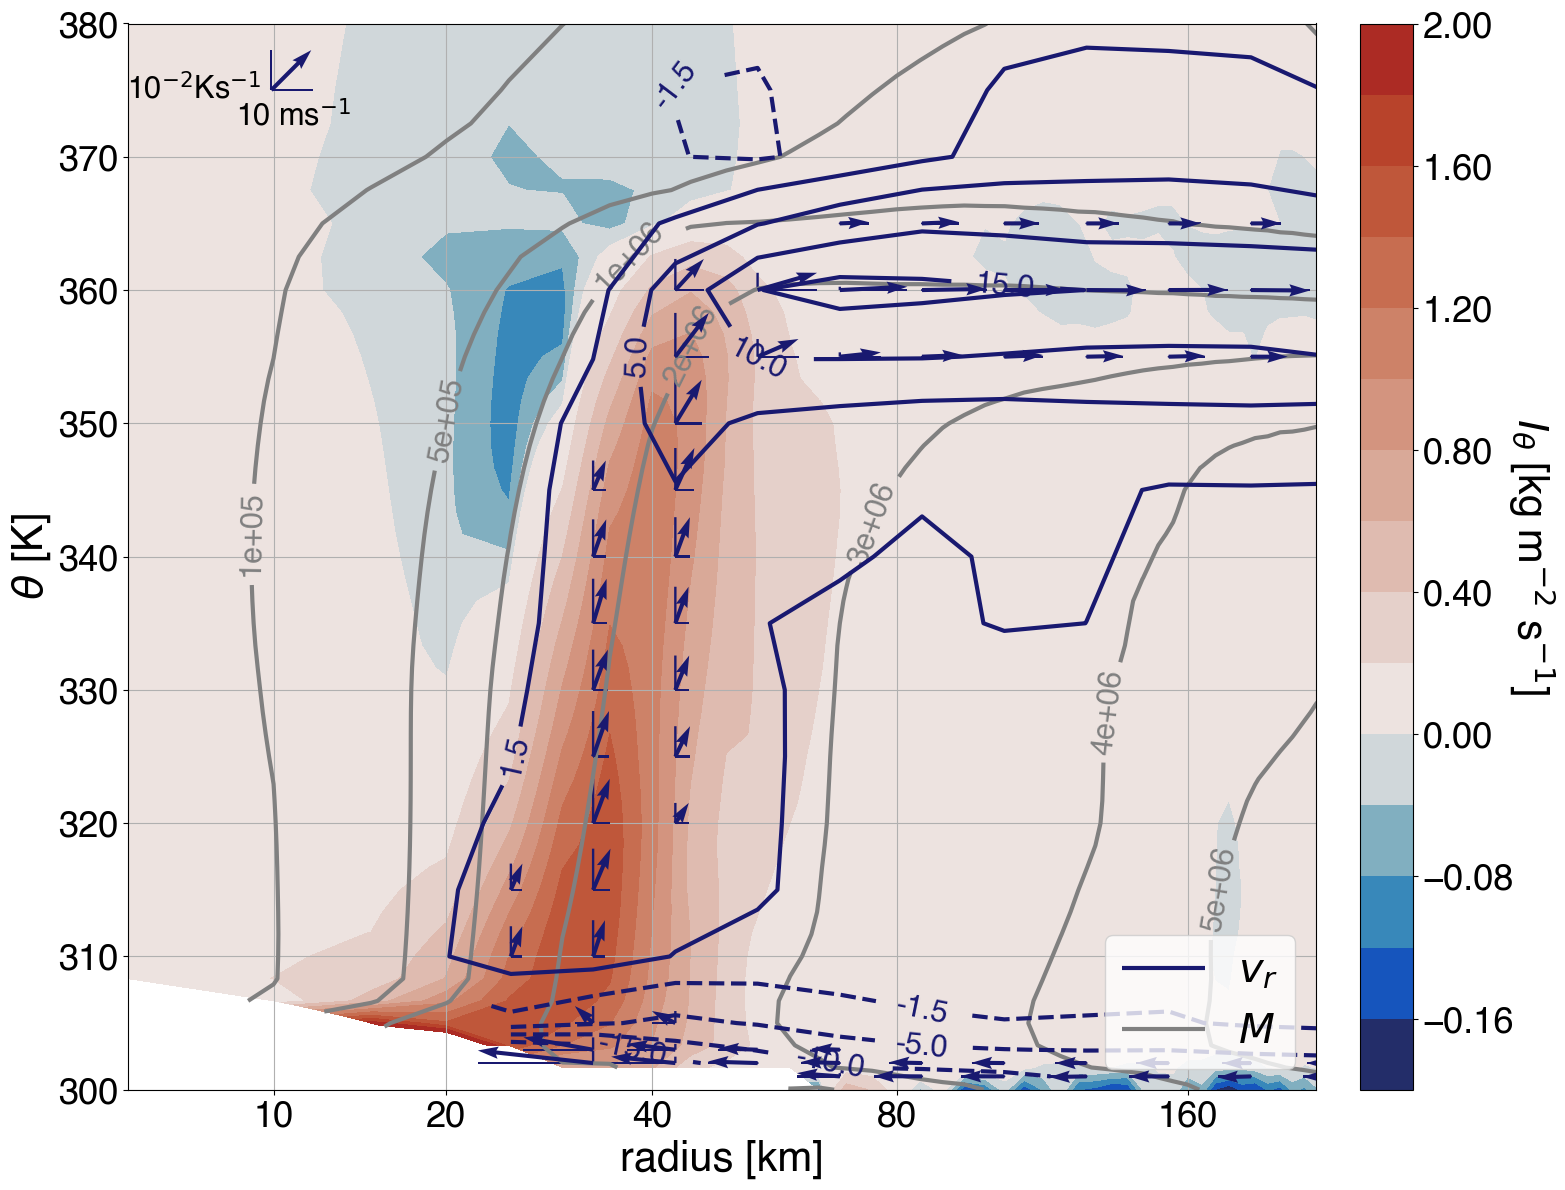

In [19]:


fc = 4.25e-5
dsl = ds.isel(valid_time=range(12,25)).mean('valid_time')
rz_range = {'r':slice(0,45), 'z':slice(3,47)}
dsl['zeros'] = xr.zeros_like(dsl.u_rad)
dsls = dsl.isel(rz_range)
cimflevels = [*np.arange(-0.2,0,0.04),*np.arange(0,2.01,0.2)]
arrowscale = 0.025
Mlevels = np.array([0.1,0.5,1,2,3,4,5,6,7])*1e6
M = dsls.v_tan*dsls.r + 0.5*fc*dsls.r**2
norm = colors.TwoSlopeNorm(vcenter=0, vmin=-.2, vmax=3) # CenteredNorm (default)
fig = plt.figure(figsize=(16,12))
p1 = plt.contourf(dsls.r/1000, dsls.theta, dsls.cimf, cmap=cmocean.cm.balance, levels=cimflevels,
                  norm=norm, zorder=0)
# p1 = dsls.cimf.plot.contourf(
#     y='theta', cmap=cmocean.cm.balance, 
#     levels=cimflevels, add_colorbar=False, norm=norm, zorder=0)
ax = p1.axes
ax.grid()
ax.xaxis.set_zorder(1)
ax.yaxis.set_zorder(1)
#p12 = dsls.cimf.plot.contour(ax=ax, y='theta', colors='white', linestyles='--', levels=[0], zorder=0)
ax.set_xscale('function', functions=(lambda x: x**(1/4), lambda x: x**(4)))

dslsi = dsls.swap_dims({'z':'theta'}).interp(r=np.arange(1.6,4.01,0.16)**4*1e3, 
                                             theta=[*[301,302,303],*range(305,381,5)], method="linear")
Vabs = np.sqrt((dslsi.u_rad/1000)**2+(dslsi.cimf/dslsi.sigma)**2)
dslsiq = dslsi.where(Vabs>0.006, np.nan)
p2 = ax.quiver(dslsiq.r/1000, dslsiq.theta, (dslsiq.u_rad/1000), (dslsiq.cimf/dslsiq.sigma),
                angles='uv', scale_units='inches', units='width', scale=arrowscale, zorder=3, color='midnightblue') #dodgerblue
p2r = ax.quiver(dslsiq.r/1000, dslsiq.theta, (dslsiq.u_rad/1000), dslsiq.zeros,
               angles='uv', scale_units='inches', units='width', scale=arrowscale, zorder=2, headaxislength=0,
               headlength=0, headwidth=0, width=0.002, color=p2.get_facecolor())
p2t = ax.quiver(dslsiq.r/1000, dslsiq.theta, dslsiq.u_rad*1e-7, (dslsiq.cimf/dslsiq.sigma),
               angles='uv', scale_units='inches', units='width', scale=arrowscale, zorder=2, headaxislength=0,
               headlength=0, headwidth=0, width=0.002, color=p2.get_facecolor())
#ax.quiverkey(p2r,9.7,373,5/(1000*arrowscale*fig.get_figwidth()),'5 m/s', coordinates='data', labelpos='S', fontproperties={'size':14}, zorder=4)
ax.quiverkey(p2r,10.9,375,10/1000,r'10 ms$^{-1}$', coordinates='data', labelpos='S', fontproperties={'size':22}, zorder=4)
ax.quiverkey(p2t,9.9,375,0.01,r'10$^{-2}$Ks$^{-1}$', coordinates='data', labelpos='W', fontproperties={'size':22}, angle=90, zorder=4)
ax.quiverkey(p2,9.9,375,0.01414,'', coordinates='data', labelpos='W', fontproperties={'size':22}, angle=45, zorder=4)
u_rad_levels = np.array([-15,-10,-5,-1.5,1.5,5,10,15])
p22 = ax.contour(dslsi.r/1000, dslsi.theta, dslsi.u_rad, levels=u_rad_levels, linestyles=np.where(u_rad_levels>=0,'-','--'), 
                 colors=[p2.get_facecolor()], zorder=3, linewidths=3)
h22 = p22.legend_elements()[0][-1]
#p22 = dslsi.u_rad.plot.contour(ax=ax, y='theta', levels=u_rad_levels, linestyles=np.where(u_rad_levels>=0,'-','--'), colors=[p2.get_facecolor()], zorder=3)
ax.clabel(p22, fmt=lambda x:f"{x}",fontsize=22)

p3 = ax.contour(dsls.r/1000, dsls.theta, M, levels=Mlevels, colors=['grey'], zorder=2, linestyles=['-'], linewidths=3)
h3 = p3.legend_elements()[0][0]
ax.legend(handles=[h22,h3], labels=[r'$v_r$',r'$M$'], fontsize=30, loc='lower right')
#p3 = M.plot.contour(ax=ax, y='theta', levels=Mlevels, colors='grey', zorder=2)
ax.clabel(p3,inline=True,inline_spacing=1,fontsize=22, zorder=2, fmt=lambda x:f"{x:.0e}")
cb = plt.colorbar(p1, ax=ax, pad=0.03)
#cb.add_lines(p12, erase=True)
#cb.lines[-1].set_linestyles(p12.linestyles)
#cb.ax.set_title(r'$kgm^{-2}s^{-1}$',fontsize=26, pad=20)
cb.ax.set_ylabel(r'$I_{\theta}$ [kg m$^{-2}$ s$^{-1}$]', fontsize=30, rotation=270, labelpad=30)
cb.ax.tick_params(axis='y',labelsize=26)

#proxyartists = [lines.Line2D([], [], lw=p.linewidths, color=list(p.colors)[-1], linestyle=list(p.linestyles)[-1], alpha=p.get_alpha()) for p in [p22,p22,p3]]
#proxyartists[0].set_alpha(0)
#fig.legend(proxyartists, [r'$I_{\theta}$',r'$v_r$',r'$M$'], ncols=3, fontsize=26, bbox_to_anchor=(0.61, 1.05), bbox_transform=fig.transFigure, framealpha=0)


_ = ax.set_xticks([10,20,40,80,160], labels=[10,20,40,80,160], fontsize=26)
ax.tick_params(axis='y',labelsize=26)
ax.tick_params(axis='x',labelsize=26)
plt.ylabel(r'$\theta$ [K]', fontsize=30)
plt.xlabel('radius [km]', fontsize=30)
# plt.title('Azimuthal mean cross-isentropic mass flux, \nvelocity and angular momentum'
#           +f'',fontsize=26)
plt.title('')
plt.xlim([5,210])
plt.tight_layout()
fig.savefig('lg2_cimf4.pdf',format='pdf',dpi=300,transparent=False, bbox_inches='tight')

### Old versions

In [105]:
fc = 4.25e-5
rz_range = {'r':slice(5,240), 'z':slice(3,47)}
dsl['zeros'] = xarray.zeros_like(dsl.u_rad)
dsls = dsl.sel(rz_range)
cimflevels = np.arange(-0.2,2.01,0.2)
arrowscale = 0.025
Mlevels = [0.1e6,0.5e6,1e6,2e6,3e6,4e6,5e6,6e6,7e6]
M = 1e3*dsls.v_tan*dsls.r + 0.5e3*fc*dsls.r**2
norm = colors.CenteredNorm()
fig = plt.figure(figsize=(16,12))
p1 = plt.contourf(dsls.r, dsls.theta, dsls.cimf, cmap=cmocean.cm.balance, levels=cimflevels,
                  norm=norm, zorder=0)
# p1 = dsls.cimf.plot.contourf(
#     y='theta', cmap=cmocean.cm.balance, 
#     levels=cimflevels, add_colorbar=False, norm=norm, zorder=0)
ax = p1.axes
ax.grid()
ax.xaxis.set_zorder(1)
ax.yaxis.set_zorder(1)
#p12 = dsls.cimf.plot.contour(ax=ax, y='theta', colors='white', linestyles='--', levels=[0], zorder=0)
ax.set_xscale('function', functions=(lambda x: x**(1/4), lambda x: x**(4)))

dslsi = dsls.swap_dims({'z':'theta'}).interp(r=np.arange(1.6,4.01,0.16)**4, 
                                             theta=[*[301,302,303],*range(305,381,5)])
Vabs = np.sqrt((dslsi.u_rad/1000)**2+(dslsi.cimf/dslsi.sigma)**2)
dslsiq = dslsi.where(Vabs>0.006, np.nan)
p2 = ax.quiver(dslsiq.r, dslsiq.theta, (dslsiq.u_rad/1000), (dslsiq.cimf/dslsiq.sigma),
                angles='uv', scale_units='inches', units='width', scale=arrowscale, zorder=3, color='midnightblue') #dodgerblue

p2r = ax.quiver(dslsiq.r, dslsiq.theta, (dslsiq.u_rad/1000), dslsiq.zeros,
               angles='uv', scale_units='inches', units='width', scale=arrowscale, zorder=2, headaxislength=0,
               headlength=0, headwidth=0, width=0.002, color=p2.get_facecolor())
p2t = ax.quiver(dslsiq.r, dslsiq.theta, dslsiq.u_rad*1e-7, (dslsiq.cimf/dslsiq.sigma),
               angles='uv', scale_units='inches', units='width', scale=arrowscale, zorder=2, headaxislength=0,
               headlength=0, headwidth=0, width=0.002, color=p2.get_facecolor())
#ax.quiverkey(p2r,9.7,373,5/(1000*arrowscale*fig.get_figwidth()),'5 m/s', coordinates='data', labelpos='S', fontproperties={'size':14}, zorder=4)
ax.quiverkey(p2r,9.5,373,10/1000,'10 m/s', coordinates='data', labelpos='S', fontproperties={'size':14}, zorder=4)
ax.quiverkey(p2t,8.5,372.89,0.01,'10 mK/s', coordinates='data', labelpos='W', fontproperties={'size':14}, angle=90, zorder=4)
ax.quiverkey(p2,8.5,372.89,0.01414,'', coordinates='data', labelpos='W', fontproperties={'size':14}, angle=45, zorder=4)
u_rad_levels = np.array([-15,-10,-5,-1.5,1.5,5,10,15])
p22 = dslsi.u_rad.plot.contour(ax=ax, y='theta', levels=u_rad_levels, linestyles=np.where(u_rad_levels>=0,'-','--'), colors=[p2.get_facecolor()], zorder=3)
ax.clabel(p22, fmt=lambda x:f"{x} m/s",fontsize=16)

p3 = M.plot.contour(ax=ax, y='theta', levels=Mlevels, colors='grey', zorder=2)
ax.clabel(p3,inline=True,inline_spacing=1,fontsize=18, zorder=2, fmt=lambda x:f"{x:.0f}" if x!=3000000 else f"{x:.0f}"+r" $ms^{-2}$")
cb = plt.colorbar(p1, ax=ax, pad=0.03)
#cb.add_lines(p12, erase=True)
#cb.lines[-1].set_linestyles(p12.linestyles)
cb.ax.set_title(r'$kgm^{-2}s^{-1}$',fontsize=22, pad=20)
cb.ax.tick_params(axis='y',labelsize=22)

_ = ax.set_xticks([10,20,40,80,160],fontsize=22)
ax.tick_params(axis='y',labelsize=22)
ax.tick_params(axis='x',labelsize=22)
plt.ylabel('theta [K]', fontsize=22)
plt.xlabel('radius [km]', fontsize=22)
# plt.title('Azimuthal mean cross-isentropic mass flux, \nvelocity and angular momentum'
#           +f'',fontsize=26)
plt.title('')
plt.xlim([5,210])
plt.tight_layout()
fig.savefig('fig/lg2_cimf3.png',dpi=300,transparent=False, bbox_inches='tight')

None


In [ ]:
fc = 4.25e-5
dsl['zeros'] = xarray.zeros_like(dsl.u_rad)
dsls = dsl.sel(rz_range)
cimflevels = 21
arrowscale = 0.05
Mlevels = [0.1e6,0.5e6,1e6,2e6,3e6,4e6,5e6,6e6,7e6]
M = 1e3*dsls.v_tan*dsls.r + 0.5e3*fc*dsls.r**2
norm = colors.CenteredNorm()
fig = plt.figure(figsize=(16,12))
p1 = dsls.cimf.plot.contourf(
    y='theta', cmap=cmocean.cm.balance, 
    levels=cimflevels, add_colorbar=False, norm=norm, zorder=0)
ax = p1.axes
ax.grid()
ax.xaxis.set_zorder(1)
ax.yaxis.set_zorder(1)
p12 = dsls.cimf.plot.contour(ax=ax, y='theta', colors='white', linestyles='--', levels=[0], zorder=0)
ax.set_xscale('function', functions=(lambda x: x**(1/4), lambda x: x**(4)))
dslsi = dsls.swap_dims({'z':'theta'}).interp(r=np.arange(1.6,4.21,0.1)**4, theta=np.arange(300,380,2))
p2 = ax.quiver(dslsi.r, dslsi.theta, (dslsi.u_rad/1000).where(np.abs(dslsi.u_rad)>1.5, np.nan), dslsi.cimf/dslsi.sigma,
                angles='uv', scale_units='inches', scale=arrowscale, zorder=3)
ax.quiverkey(p2,9.6,375,10/(1000*arrowscale*fig.get_figwidth()),'10 m/s', coordinates='data', labelpos='S', fontproperties={'size':14}, zorder=4)
ax.quiverkey(p2,8.9,374.89,0.01/(arrowscale*fig.get_figheight()),'10mK/s', coordinates='data', labelpos='W', fontproperties={'size':14}, angle=90, zorder=4)
p22 = dslsi.u_rad.plot.contour(ax=ax, y='theta', levels=[-1.5,1.5], colors=[p2.get_facecolor()], zorder=3)
# p2 = dsls.interp(r=np.arange(1.6,4.21,0.2)**4).plot.quiver('r','theta','u_rad','zeros',
#                       ax=ax,
#                       scale=1,
#                       scale_units='x')
p3 = M.plot.contour(ax=ax, y='theta', levels=Mlevels, colors='grey', zorder=2)
ax.clabel(p3,inline=True,inline_spacing=1,fontsize=18, zorder=2)
cb = plt.colorbar(p1, ax=ax)
cb.add_lines(p12, erase=True)
cb.lines[-1].set_linestyles(p12.linestyles)
cb.ax.set_title(r'$kgm^{-2}s^{-1}$',fontsize=22)
cb.ax.tick_params(axis='y',labelsize=22)

_ = ax.set_xticks([10,20,40,80,160,320],fontsize=22)
ax.tick_params(axis='y',labelsize=22)
ax.tick_params(axis='x',labelsize=22)
plt.ylabel('theta [K]', fontsize=22)
plt.xlabel('radius [km]', fontsize=22)
plt.title('Cross-isentropic mass flux, radial velocity\nand angular momentum'
          +f'',fontsize=26)
#fig.savefig('fig/lg2_cimf.png',dpi=300,transparent=False)